In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import dill
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
import sgm
from pkgs.MindEyeV2.src.generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder, FrozenCLIPEmbedder, FrozenOpenCLIPEmbedder2
from pkgs.MindEyeV2.src.generative_models.sgm.models.diffusion import DiffusionEngine
from pkgs.MindEyeV2.src.generative_models.sgm.util import append_dims
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import pkgs.MindEyeV2.src.utils
from pkgs.MindEyeV2.src.models import *

import lovely_tensors as lt
lt.monkey_patch()

from csng.data import get_dataloaders
from csng.utils.mix import seed_all
from csng.utils.data import crop
from csng.utils.data import crop, standardize, normalize
from csng.data import get_dataloaders
from csng.utils.comparison import plot_reconstructions

DATA_PATH_BRAINREADER = os.path.join(os.environ["DATA_PATH"], "brainreader")
DATA_PATH_MINDEYE = os.path.join(os.environ["DATA_PATH"], "mindeye")
DATA_PATH_MINDEYE_CACHE = os.path.join(DATA_PATH_MINDEYE, "cache")
print(f"{DATA_PATH_BRAINREADER=}\n{DATA_PATH_MINDEYE=}\n{DATA_PATH_MINDEYE_CACHE=}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)

!nvidia-smi

/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


DATA_PATH_BRAINREADER='/scratch/izar/sobotka/csng/brainreader'
DATA_PATH_MINDEYE='/scratch/izar/sobotka/csng/mindeye'
DATA_PATH_MINDEYE_CACHE='/scratch/izar/sobotka/csng/mindeye/cache'
device: cuda
Fri Apr  4 01:53:07 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:86:00.0 Off |                  Off |
| N/A   38C    P0              26W / 250W |      0

In [2]:
model_name = "csng_mouse_v1__03-04-25_16-06"
data_path = DATA_PATH_BRAINREADER
cache_dir = DATA_PATH_MINDEYE_CACHE
evals_dir = f'{DATA_PATH_MINDEYE}/evals/{model_name}'
assert os.path.exists(evals_dir)
print("\n".join(os.listdir(evals_dir)))

cfg.pt
subj21067-10-18_test_all_predcaptions.pt
subj21067-10-18_test_all_images_before_transform.pt
subj21067-10-18_test_all_voxels.pt
subj21067-10-18_test_all_images.pt
subj21067-10-18_test_all_clipvoxels.pt
subj21067-10-18_test_all_blurryrecons.pt
subj21067-10-18_test_all_recons.pt


In [3]:
# Load pretrained model ckpt
tag = "best"
cfg = torch.load(f'{DATA_PATH_MINDEYE}/train_logs/{model_name}/{tag}.pth', map_location='cpu')['cfg']
cfg

{'device': 'cuda',
 'data_type': torch.float32,
 'seed': 0,
 'data': {'mixing_strategy': 'parallel_min',
  'max_training_batches': None,
  'mouse_v1': {'dataset_fn': 'sensorium.datasets.static_loaders',
   'dataset_config': {'paths': ['/scratch/izar/sobotka/csng/mouse_v1_sensorium22/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip'],
    'normalize': True,
    'z_score_responses': True,
    'scale': 0.25,
    'include_behavior': False,
    'add_behavior_as_channels': False,
    'include_eye_position': True,
    'exclude': None,
    'file_tree': True,
    'cuda': False,
    'batch_size': 8,
    'drop_last': True,
    'use_cache': False},
   'skip_train': False,
   'skip_val': False,
   'skip_test': False,
   'normalize_neuron_coords': True,
   'average_test_multitrial': True,
   'save_test_multitrial': True,
   'test_batch_size': 7,
   'device': 'cuda',
   'batch_size': 8}},
 'wandb': {'project': 'MindEye', 'group': 'mindeye'},
 'data_name': 'mouse_v1',
 'crop_wins': 

In [4]:
# Some of these files are downloadable from huggingface: https://huggingface.co/datasets/pscotti/mindeyev2/tree/main/evals
# The others are obtained from running recon_inference.ipynb first with your desired model
subj_name = "subj21067-10-18"
data_tier = "test"

# subj_list_idx = list(cfg["model"]["num_voxels"].keys()).index(subj_name)
all_images = torch.load(f"{evals_dir}/{subj_name}_{data_tier}_all_images.pt")
all_recons = torch.load(f"{evals_dir}/{subj_name}_{data_tier}_all_recons.pt") # these are the unrefined MindEye2 recons!
all_clipvoxels = torch.load(f"{evals_dir}/{subj_name}_{data_tier}_all_clipvoxels.pt")
all_blurryrecons = torch.load(f"{evals_dir}/{subj_name}_{data_tier}_all_blurryrecons.pt")
all_predcaptions = torch.load(f"{evals_dir}/{subj_name}_{data_tier}_all_predcaptions.pt")

all_images = transforms.Resize((768,768))(all_images).float()
if all_images.size(1):
    all_images = all_images.repeat(1,3,1,1)
all_recons = transforms.Resize((768,768))(all_recons).float()
all_blurryrecons = transforms.Resize((768,768))(all_blurryrecons).float()

print(model_name)
print("\n".join([str(all_images), str(all_recons), str(all_clipvoxels), str(all_blurryrecons), str(len(all_predcaptions))]))
seed_all(cfg["seed"])

/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


csng_mouse_v1__03-04-25_16-06
tensor[100, 3, 768, 768] n=176947200 (0.7Gb) x∈[-1.750, 2.261] μ=0.080 σ=0.871
tensor[100, 3, 768, 768] n=176947200 (0.7Gb) x∈[-1.092, 1.210] μ=-0.174 σ=0.693
tensor[100, 256, 1664] n=42598400 (0.2Gb) x∈[-429.767, 428.315] μ=1.507 σ=8.352
tensor[100, 3, 768, 768] n=176947200 (0.7Gb) x∈[-1.298, 1.061] μ=-0.221 σ=0.554
100


In [5]:
### Load SDXL unCLIP model
config = OmegaConf.load("src/generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
unclip_params = config["model"]["params"]
sampler_config = unclip_params["sampler_config"]
sampler_config['params']['num_steps'] = 38
config = OmegaConf.load("src/generative_models/configs/inference/sd_xl_base.yaml")
config = OmegaConf.to_container(config, resolve=True)
refiner_params = config["model"]["params"]

network_config = refiner_params["network_config"]
denoiser_config = refiner_params["denoiser_config"]
first_stage_config = refiner_params["first_stage_config"]
conditioner_config = refiner_params["conditioner_config"]
scale_factor = refiner_params["scale_factor"]
disable_first_stage_autocast = refiner_params["disable_first_stage_autocast"]

# base_ckpt_path = '/weka/robin/projects/stable-research/checkpoints/sd_xl_base_1.0.safetensors'
base_ckpt_path = f'{cache_dir}/zavychromaxl_v30.safetensors'
base_engine = DiffusionEngine(
    network_config=network_config,
    denoiser_config=denoiser_config,
    first_stage_config=first_stage_config,
    conditioner_config=conditioner_config,
    sampler_config=sampler_config, # using the one defined by the unclip
    scale_factor=scale_factor,
    disable_first_stage_autocast=disable_first_stage_autocast,
    ckpt_path=base_ckpt_path,
)
base_engine.eval().requires_grad_(False)
base_engine.to(cfg["device"])

base_text_embedder1 = FrozenCLIPEmbedder(
    layer=conditioner_config['params']['emb_models'][0]['params']['layer'],
    layer_idx=conditioner_config['params']['emb_models'][0]['params']['layer_idx'],
)
base_text_embedder1.to(cfg["device"])

base_text_embedder2 = FrozenOpenCLIPEmbedder2(
    arch=conditioner_config['params']['emb_models'][1]['params']['arch'],
    version=conditioner_config['params']['emb_models'][1]['params']['version'],
    freeze=conditioner_config['params']['emb_models'][1]['params']['freeze'],
    layer=conditioner_config['params']['emb_models'][1]['params']['layer'],
    always_return_pooled=conditioner_config['params']['emb_models'][1]['params']['always_return_pooled'],
    legacy=conditioner_config['params']['emb_models'][1]['params']['legacy'],
)
base_text_embedder2.to(cfg["device"])

batch={"txt": "",
      "original_size_as_tuple": torch.ones(1, 2).to(cfg["device"]) * 768,
      "crop_coords_top_left": torch.zeros(1, 2).to(cfg["device"]),
      "target_size_as_tuple": torch.ones(1, 2).to(cfg["device"]) * 1024}
out = base_engine.conditioner(batch)
crossattn = out["crossattn"].to(cfg["device"])
vector_suffix = out["vector"][:,-1536:].to(cfg["device"])
print("crossattn", crossattn.shape)
print("vector_suffix", vector_suffix.shape)
print("---")

batch_uc={"txt": "painting, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, deformed, ugly, blurry, bad anatomy, bad proportions, extra limbs, cloned face, skinny, glitchy, double torso, extra arms, extra hands, mangled fingers, missing lips, ugly face, distorted face, extra legs, anime",
      "original_size_as_tuple": torch.ones(1, 2).to(cfg["device"]) * 768,
      "crop_coords_top_left": torch.zeros(1, 2).to(cfg["device"]),
      "target_size_as_tuple": torch.ones(1, 2).to(cfg["device"]) * 1024}
out = base_engine.conditioner(batch_uc)
crossattn_uc = out["crossattn"].to(cfg["device"])
vector_uc = out["vector"].to(cfg["device"])
print("crossattn_uc", crossattn_uc.shape)
print("vector_uc", vector_uc.shape)

SpatialTransformer: Found context dims [2048] of depth 1, which does not match the specified 'depth' of 2. Setting context_dim to [2048, 2048] now.
SpatialTransformer: Found context dims [2048] of depth 1, which does not match the specified 'depth' of 2. Setting context_dim to [2048, 2048] now.
SpatialTransformer: Found context dims [2048] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048] now.
SpatialTransformer: Found context dims [2048] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048] now.
SpatialTransformer: Found context dims [2048] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048] now.
SpatialTransformer: Found context dims [2048] of depth 1, which does not match the specified 'depth' of 10. Setti

Initialized embedder #0: FrozenCLIPEmbedder with 123060480 params. Trainable: False
Initialized embedder #1: FrozenOpenCLIPEmbedder2 with 694659841 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #3: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #4: ConcatTimestepEmbedderND with 0 params. Trainable: False
Restored from /scratch/izar/sobotka/csng/mindeye/cache/zavychromaxl_v30.safetensors with 1 missing and 1 unexpected keys
Missing Keys: ['denoiser.sigmas']
Unexpected Keys: ['conditioner.embedders.0.transformer.text_model.embeddings.position_ids']
crossattn torch.Size([1, 77, 2048])
vector_suffix torch.Size([1, 1536])
---
crossattn_uc torch.Size([1, 77, 2048])
vector_uc torch.Size([1, 2816])


In [6]:
from pkgs.MindEyeV2.src import utils
if utils.is_interactive(): plotting=True

num_samples = 1 # PS: I tried increasing this to 16 and picking highest cosine similarity like we did in MindEye1, it didnt seem to increase eval performance!
img2img_timepoint = 13 # 9 # higher number means more reliance on prompt, less reliance on matching the conditioning image
base_engine.sampler.guider.scale = 5 # 5 # cfg
def denoiser(x, sigma, c):
    return base_engine.denoiser(base_engine.model, x, sigma, c)

if plotting or num_samples > 1:
    clip_img_embedder = FrozenOpenCLIPImageEmbedder(
        arch=cfg["model"]["clip_img_embedder_arch"],
        version=cfg["model"]["clip_img_embedder_version"],
        output_tokens=True,
        only_tokens=True,
        cache_dir=cfg["model"]["cache_dir"],
    )
    clip_img_embedder.to(cfg["device"])

In [7]:
plotting = False

In [8]:
all_enhancedrecons = None
for img_idx in tqdm(range(len(all_recons))):
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float32), base_engine.ema_scope():
        base_engine.sampler.num_steps = 25

        image = all_recons[[img_idx]]

        if plotting:
            print("blur pixcorr:", utils.pixcorr(all_blurryrecons[[img_idx]].float(), all_images[[img_idx]].float()))
            print("blur cossim:",nn.functional.cosine_similarity(clip_img_embedder(utils.resize(all_blurryrecons[[img_idx]].float(),256).to(cfg["device"])).flatten(1), 
                                                         clip_img_embedder(utils.resize(all_images[[img_idx]].float(),224).to(cfg["device"])).flatten(1)))

            print("recon pixcorr:",utils.pixcorr(image,all_images[[img_idx]].float()))
            print("recon cossim:",nn.functional.cosine_similarity(clip_img_embedder(utils.resize(image,224).to(cfg["device"])).flatten(1), 
                                                         clip_img_embedder(utils.resize(all_images[[img_idx]].float(),224).to(cfg["device"])).flatten(1)))

        image = image.to(cfg["device"])
        prompt = all_predcaptions[[img_idx]][0]
        # prompt = ""
        if plotting: 
            print("prompt:",prompt)
            # plt.imshow(transforms.ToPILImage()(all_blurryrecons[img_idx].float()))
            plt.imshow(all_blurryrecons[img_idx].permute(1,2,0).float().cpu())
            plt.title("blurry")
            plt.show()
            # plt.imshow(transforms.ToPILImage()(all_recons[img_idx].float()))
            plt.imshow(all_recons[img_idx].permute(1,2,0).float().cpu())
            plt.title("recon")
            plt.show()
            plt.imshow(all_images[img_idx].permute(1,2,0).cpu().numpy())
            plt.title("GT")
            plt.show()

        # z = torch.randn(num_samples,4,96,96).to(device)
        assert image.shape[-1]==768
        # z = base_engine.encode_first_stage(image*2-1).repeat(num_samples,1,1,1)
        z = base_engine.encode_first_stage(image).repeat(num_samples,1,1,1) # already z-scored

        openai_clip_text = base_text_embedder1(prompt)
        clip_text_tokenized, clip_text_emb  = base_text_embedder2(prompt)
        clip_text_emb = torch.hstack((clip_text_emb, vector_suffix))
        clip_text_tokenized = torch.cat((openai_clip_text, clip_text_tokenized),dim=-1)
        c = {"crossattn": clip_text_tokenized.repeat(num_samples,1,1), "vector": clip_text_emb.repeat(num_samples,1)}
        uc = {"crossattn": crossattn_uc.repeat(num_samples,1,1), "vector": vector_uc.repeat(num_samples,1)}

        noise = torch.randn_like(z)
        sigmas = base_engine.sampler.discretization(base_engine.sampler.num_steps).to(cfg["device"])
        init_z = (z + noise * append_dims(sigmas[-img2img_timepoint], z.ndim)) / torch.sqrt(1.0 + sigmas[0] ** 2.0)
        sigmas = sigmas[-img2img_timepoint:].repeat(num_samples,1)

        base_engine.sampler.num_steps = sigmas.shape[-1] - 1
        noised_z, _, _, _, c, uc = base_engine.sampler.prepare_sampling_loop(init_z, cond=c, uc=uc, 
                                                            num_steps=base_engine.sampler.num_steps)
        for timestep in range(base_engine.sampler.num_steps):
            noised_z = base_engine.sampler.sampler_step(sigmas[:,timestep],
                                                        sigmas[:,timestep+1],
                                                        denoiser, noised_z, cond=c, uc=uc, gamma=0)
        samples_z_base = noised_z
        samples_x = base_engine.decode_first_stage(samples_z_base)
        assert (all_images.amin() < 0 or all_images.amax() > 1)
        samples = samples_x
        # samples = torch.clamp((samples_x + 1.0) / 2.0, min=0.0, max=1.0)

        # find best sample
        if plotting==False and num_samples==1:
            samples = samples[0]
        else:
            sample_cossim = nn.functional.cosine_similarity(clip_img_embedder(utils.resize(samples,224).to(cfg["device"])).flatten(1), 
                                clip_img_embedder(utils.resize(all_images[[img_idx]].float(),224).to(cfg["device"])).flatten(1))
            which_sample = torch.argmax(sample_cossim)
            best_cossim = torch.max(sample_cossim)

            if plotting:
                print("samples", samples.shape)
                for n in range(num_samples):
                    # recon = transforms.ToPILImage()(samples[n])
                    recon = samples[n].permute(1,2,0).float().cpu()
                    plt.imshow(recon)
                    plt.title(f"enhanced recon {n}")
                    plt.show()
                    if (n==which_sample).item(): print("CHOSEN ABOVE")
                    print("upsampled pixcorr:",utils.pixcorr(samples[[n]].cpu(),all_images[[img_idx]].float()))
                    print("upsampled cossim:",nn.functional.cosine_similarity(clip_img_embedder(utils.resize(samples[[n]],224).to(cfg["device"])).flatten(1), 
                                                         clip_img_embedder(utils.resize(all_images[[img_idx]].float(),224).to(cfg["device"])).flatten(1)))
            samples = samples[which_sample]

        samples = samples.cpu()[None]
        if all_enhancedrecons is None:
            all_enhancedrecons = samples
        else:
            all_enhancedrecons = torch.vstack((all_enhancedrecons, samples))

all_enhancedrecons = transforms.Resize((256,256))(all_enhancedrecons).float()
print("all_enhancedrecons", all_enhancedrecons.shape)
torch.save(all_enhancedrecons,f"{evals_dir}/{subj_name}_{data_tier}_all_enhancedrecons.pt")
print(f"saved {evals_dir}/{subj_name}_{data_tier}_all_enhancedrecons.pt")

if not utils.is_interactive():
    sys.exit(0)

  0%|                                | 0/100 [00:00<?, ?it/s]/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████████████████| 100/100 [13:50<00:00,  8.31s/it]


all_enhancedrecons torch.Size([100, 3, 256, 256])
saved /scratch/izar/sobotka/csng/mindeye/evals/csng_mouse_v1__03-04-25_16-06/subj21067-10-18_test_all_enhancedrecons.pt


## Final plotting for publication

In [9]:
subj_name = "subj21067-10-18"
data_tier = "test"
# subj_name = "subj06"
# subj_name = "subjcat_v1"
loaded_all_images = torch.load(f"{evals_dir}/{subj_name}_{data_tier}_all_images.pt")
loaded_all_blurryrecons = torch.load(f"{evals_dir}/{subj_name}_{data_tier}_all_blurryrecons.pt")
loaded_all_enhancedrecons = torch.load(f"{evals_dir}/{subj_name}_{data_tier}_all_enhancedrecons.pt")

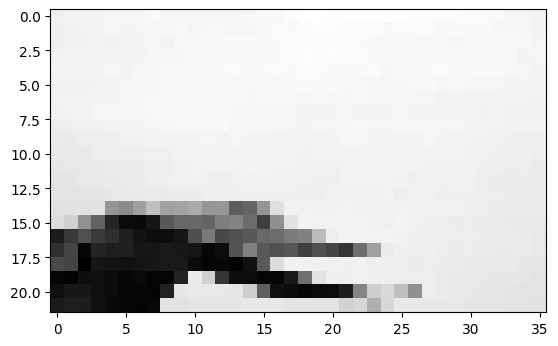

In [10]:
### get image mean and std for inverting z-scoring
_dls, _ = get_dataloaders(cfg)

if "data_name" not in cfg:
    if "brainreader_mouse" in cfg["data"]:
        cfg["data_name"] = "brainreader_mouse"
    elif "mouse_v1" in cfg["data"]:
        cfg["data_name"] = "mouse_v1"
    elif "cat_v1" in cfg["data"]:
        cfg["data_name"] = "cat_v1"
    else:
        raise NotImplementedError

if cfg["data_name"] == "brainreader_mouse":
    zscore_trans = _dls[data_tier][cfg["data_name"]].datasets[list(cfg["model"]["num_voxels"].keys()).index(subj_name)].stim_transform.transforms[-1]
    assert isinstance(zscore_trans, transforms.Normalize)
    assert isinstance(zscore_trans.mean, float)

    inv_zscore_trans = transforms.Compose([
        transforms.Normalize(
            mean=0.,
            std=1/zscore_trans.std
        ),
        transforms.Normalize(
            mean=-zscore_trans.mean,
            std=1.
        )
    ])
elif cfg["data_name"] == "mouse_v1":
    dset = _dls["train"][cfg["data_name"]].datasets[list(cfg["model"]["num_voxels"].keys()).index(subj_name)]
    assert dset.transforms[0]._inputs_mean > 50 # check that indeed the not z-scored data is 0-255
    inv_zscore_trans = lambda x: dset.transforms[0]._itransforms["images"](x) / 255
elif cfg["data_name"] == "cat_v1":
    dset = _dls["train"][cfg["data_name"]].datasets[list(cfg["model"]["num_voxels"].keys()).index(subj_name)]
    mean, std = dset.stim_transform.transforms[-1].mean, dset.stim_transform.transforms[-1].std
    inv_zscore_trans = transforms.Compose([
        transforms.Normalize(
            mean=0,
            std=1/std
        ),
        transforms.Normalize(
            mean=-mean,
            std=1
        ),
        transforms.Normalize(
            mean=0,
            std=100
        )
    ])
else:
    raise NotImplementedError
plt.imshow(inv_zscore_trans(loaded_all_images[[0]])[0,0], cmap="gray")

all_images=tensor[100, 1, 22, 36] n=79200 (0.3Mb) x∈[0., 1.000] μ=0.456 σ=0.228
all_recons=tensor[100, 1, 22, 36] n=79200 (0.3Mb) x∈[0.182, 0.687] μ=0.393 σ=0.141
all_recons_zscored=tensor[100, 1, 22, 36] n=79200 (0.3Mb) x∈[-1.021, 1.006] μ=-0.175 σ=0.565


/tmp/2588571/ipykernel_3066302/961271408.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  all_recons = torch.tensor([


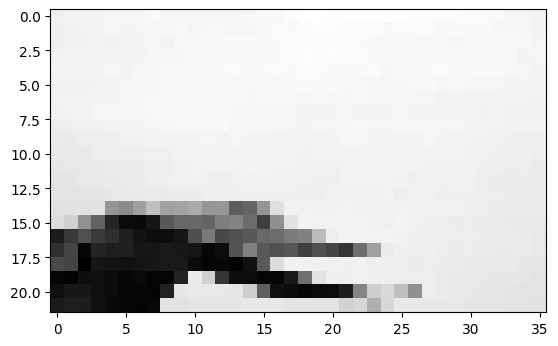

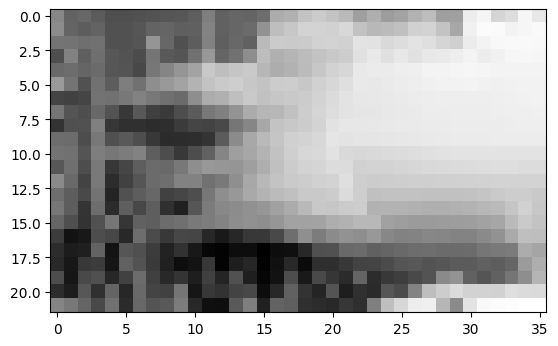

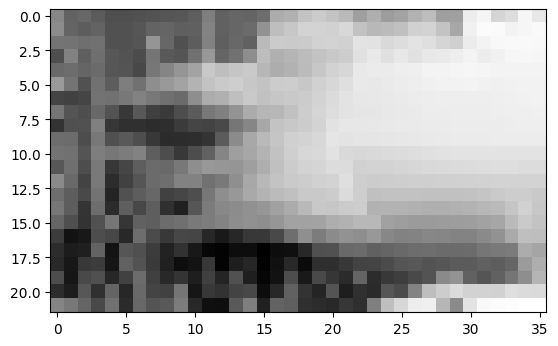

In [11]:
### prepare data for visualization
if cfg["data_name"] == "brainreader_mouse":
    target_shape = (36, 64)
elif cfg["data_name"] == "mouse_v1":
    target_shape = (22, 36)
elif cfg["data_name"] == "cat_v1":
    target_shape = (20, 20)
else:
    raise NotImplementedError
resize_fn = transforms.Resize(target_shape, antialias=True)

all_images = inv_zscore_trans(loaded_all_images).clip(0, 1)
all_enhancedrecons = inv_zscore_trans(loaded_all_enhancedrecons).clip(0, 1)
all_enhancedrecons_zscored = loaded_all_enhancedrecons
all_blurryrecons = inv_zscore_trans(loaded_all_blurryrecons).clip(0, 1)
all_blurryrecons_zscored = loaded_all_blurryrecons

### as done in the original MindEye2 evals
all_recons = all_enhancedrecons*.75 + all_blurryrecons*.25
all_recons_zscored = all_enhancedrecons_zscored*.75 + all_blurryrecons_zscored*.25
all_recons_orig = all_recons.clone()
all_recons_zscored_orig = all_recons_zscored.clone()
all_recons_zscored = resize_fn(all_recons_zscored)
all_recons = resize_fn(all_recons)

### channel matching
if all_images.size(1) != all_enhancedrecons.size(1):
    ### both in RGB
    # all_images = all_images.repeat(1,3,1,1)

    ### both in grayscale
    all_recons = torch.tensor([
        rgb2gray(all_recons[i].permute(1,2,0).numpy()) for i in range(len(all_recons))
    ]).unsqueeze(1)
    all_recons_zscored = torch.tensor([
        rgb2gray(all_recons_zscored[i].permute(1,2,0).numpy()) for i in range(len(all_recons_zscored))
    ]).unsqueeze(1)

print(f"{all_images=}\n{all_recons=}\n{all_recons_zscored=}")
plt.imshow(all_images[0].permute(1,2,0).numpy(), cmap="gray")
plt.show()
plt.imshow(all_recons[0].squeeze(0), cmap="gray")
plt.show()
plt.imshow(all_recons_zscored[0].squeeze(0), cmap="gray")
plt.show()

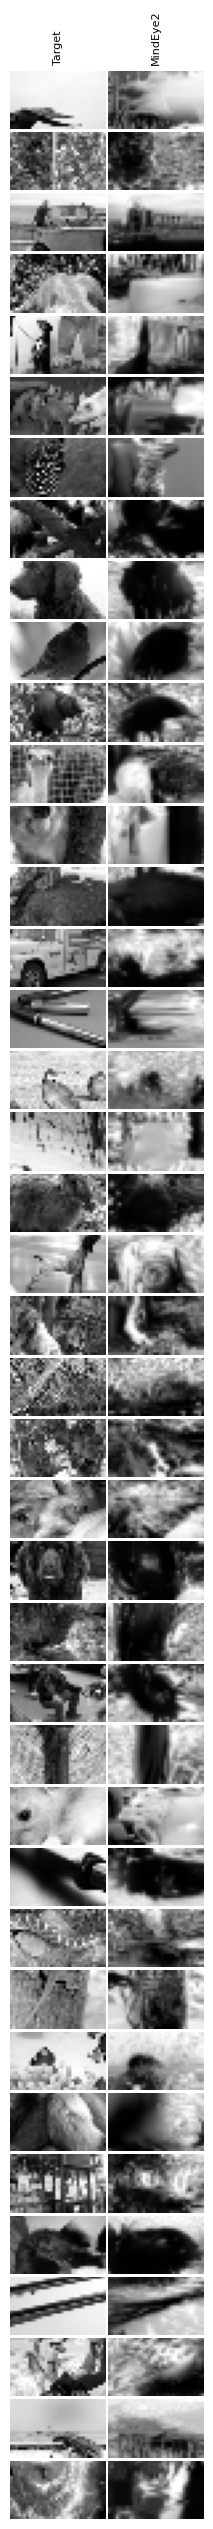

In [12]:
### plot 
max_imgs = 40
save_name = f"reconstructions"

runs = {
    "MindEye2": {
        "stim_pred_best": [all_recons],
    },
}
torch.save(all_recons, os.path.join(evals_dir, f"{subj_name}_{data_tier}_{save_name}.pt"))
torch.save(all_recons_zscored, os.path.join(evals_dir, f"{subj_name}_{data_tier}_{save_name}_zscored.pt"))
torch.save(all_recons_orig, os.path.join(evals_dir, f"{subj_name}_{data_tier}_{save_name}_orig.pt"))
torch.save(all_recons_zscored_orig, os.path.join(evals_dir, f"{subj_name}_{data_tier}_{save_name}_zscored_orig.pt"))

runs["MindEye2"]["stim_pred_best"] = [runs["MindEye2"]["stim_pred_best"][0][:max_imgs]]
plot_reconstructions(
    runs=runs,
    stim=all_images[:max_imgs],
    stim_label="Target",
    data_key=None,
    manually_standardize=False,
    crop_win=None,
    save_to=os.path.join(evals_dir, f"{save_name}_{data_tier}.pdf"),
)